In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, report_fit

In [13]:
s = '/Volumes/LabDrive/'; log = pd.read_excel('seg_results/log.xlsx')
results = pd.DataFrame(columns=['Timepoints (min)'])
results.set_index('Timepoints (min)', drop=True, inplace=True)
for file in os.listdir(s + 'Results/'):
    r = pd.read_csv(s + 'Results/' + file)
    idx = np.where((log['date']==int(file[:6]))&(log['exper_id']==file[7:-4]))[0][0]
    r['Timepoints (min)'] -= round(log.loc[idx,'t_cytokinesis']/5)*5
    r['Timepoints (min)'] = round(r['Timepoints (min)']/5)*5        # for averaging
    r[file[:-4]] = r['Normalized (AU)']
    r.drop('Intensity/pixel (AU)', axis=1, inplace=True)
    r.drop('Normalized (AU)', axis=1, inplace=True)
    r.set_index('Timepoints (min)', drop=True, inplace=True)
    results = results.merge(r, 'outer', sort=True, left_index=True, right_index=True)
    
idxs = ((~results.isna()).sum(axis=1)>=1)
r = results[idxs].mean(axis=1)
r_25 = results[idxs].quantile(0.25, axis=1)
r_75 = results[idxs].quantile(0.75, axis=1)

# smooth with small window = 10 minutes
for i in r.index:
    w = [x for x in r.index if abs(x - i) <= 5]
    r[i] = r.loc[w].mean()
    r_25[i] = r_25.loc[w].mean()
    r_75[i] = r_75.loc[w].mean()
times = (r.index-r.index.min())/60

# trim the ends
r = r.iloc[3:-21]
r_25 = r_25.iloc[3:-21]
r_75 = r_75.iloc[3:-21]
times = times[3:-21]

times_sim = np.arange(0,times.max()*60+1)/60

In [14]:
def f(y,t,p): 
    M, NP, MP = y
    dM = (10**p['r'])*(1 - M) * M
    dNP = (np.log(2)/p0['km'] + np.log(2)/p['kd'])*(M - NP)
    dMP = np.log(2)/p['kd']*(NP - MP)
    dydt = [dM, dNP, dMP]
    return dydt

def model(p):
    # ics and simulation times
    t = times_sim
    init = [0.01,0,0]
    sim = pd.DataFrame(odeint(f, init, t, args=(p,)), index=times_sim)
    return sim

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 287
    # variables        = 2
    chi-square         = 0.45801347
    reduced chi-square = 0.00160706
    Akaike info crit   = -1844.37727
    Bayesian info crit = -1837.05830
[[Variables]]
    r:   0.53924179 +/- 0.00320020 (0.59%) (init = 0)
    kd:  8.77877494 +/- 0.00567195 (0.06%) (init = 12)
[[Correlations]] (unreported correlations are < 0.100)
    C(r, kd) =  0.558
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 287
    # variables        = 2
    chi-square         = 0.45816273
    reduced chi-square = 0.00160759
    Akaike info crit   = -1844.28375
    Bayesian info crit = -1836.96478
[[Variables]]
    r:   0.72907132 +/- 0.05781313 (7.93%) (init = 0)
    kd:  8.78597898 +/- 0.11371797 (1.29%) (init = 12)
[[Correlations]] (unreported correlations are < 0.100)
    C(r, kd) =  0.817
[[Fit Statistics]]
    # fitting met

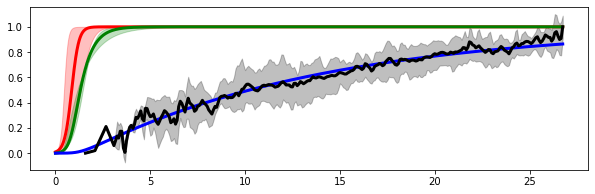

In [17]:
# LMFIT

def residuals(p):
    sim = model(p)
    data = (r-r.min())/(r.max()-r.min())
    sim = sim.loc[times.values,2].values
    return np.absolute(data - sim)

km = [5,25,45]

s = pd.DataFrame(index=times_sim)

plt.figure(figsize=(10,3)); colors = ['r','g','b']
for k in km:

    # parameters: initial values for lmfit
    p0 = {}
    p0['r'] = 0
    p0['km'] = k/60
    p0['kd'] = 12
               
    params = Parameters()
    params.add('r', value=p0['r'], min=-2, max=2)
    params.add('kd', value=p0['kd'], min=2, max=24)

    fit = minimize(residuals, params, method='leastsq')
 
    report_fit(fit)   
        
    fit_params = fit.params
    p_fit = {}
    for param in fit_params: p_fit[param] = fit_params[param].value

    # simulate
    s_ = model(p_fit).rename({0 : '0_' + str(k), 1 : '1_' + str(k), 2 : '2_' + str(k)}, axis=1)
    s = pd.concat([s,s_],axis=1)

for i in range(3): 
    plt.plot(s.index, s.loc[:,s.columns == str(i) + '_25'], c=colors[i], linewidth=3)
    plt.fill_between(s.index, s.loc[:,s.columns == str(i) + '_5'].values.flatten(), 
                     s.loc[:,s.columns == str(i) + '_45'].values.flatten(),
                     color=colors[i], alpha=0.25)
        
plt.plot(times, (r-r.min())/(r.max()-r.min()), color='k', linewidth=3)
plt.fill_between(times, (r_75-r.min())/(r.max()-r.min()), (r_25-r.min())/(r.max()-r.min()),
                 color='k', alpha=0.25)
plt.show() 

In [ ]:
# # fit dynamical model (ABC-SMC)
# from pyabc import ABCSMC, RV, Distribution
# from pyabc.transition import MultivariateNormalTransition
# import tempfile
# db_path = ("sqlite:///"+os.path.join(tempfile.gettempdir(), "test.db"))

# def f(y,t,p): 
#     M, NP, MP = y
#     dM = (10**p['r'])*(1 - M) * M
#     dNP = (np.log(2)/(25/60) + np.log(2)/p['kd'])*(M - NP)
#     dMP = np.log(2)/p['kd']*(NP - MP)
#     dydt = [dM, dNP, dMP]
#     return dydt

# def model(p):
#     # ics and simulation times
#     t = times_sim
#     init = [0.01,0,0]
#     sim = pd.DataFrame(odeint(f, init, t, args=(p,)), index=times_sim)
#     return sim

# def distance(sim,data):
#     data = (r-r.min())/(r.max()-r.min())
#     sim = sim.loc[times.values,2].values
#     return ((data - sim)**2).sum()


# # model parameters / priors
# priors = Distribution(r=RV('uniform', -1, 2),
#                       kd=RV('uniform', 2, 22))
    
# # ABC-SMC
# abc = ABCSMC(models=model, parameter_priors=priors, distance_function=distance, population_size=100)
# history = abc.new(db_path)
# h = abc.run(minimum_epsilon=0.7)

# # plot ABC-SMC fits against data
# posterior = history.get_population_extended()
# posterior.columns = [col.replace('par_','') for col in posterior.columns.values]
# posterior = posterior.loc[:,posterior.columns.values[2:-2]]

# plt.figure(figsize=(5,3))
# for idx, p in posterior.iterrows():
 
#     # simulate
#     d = {'r' : p['r'], 'kd' : p['kd']}
#     sim = model(d); sim['x'] = times_sim
#     colors = ['r','g','b']

#     for i in range(3): plt.plot(sim['x'], sim[i], c=colors[i], alpha=0.2)

# plt.plot(times, (r-r.min())/(r.max()-r.min()), color='k')
# plt.fill_between(times, (r_75-r.min())/(r.max()-r.min()), (r_25-r.min())/(r.max()-r.min()),
#                  color='k', alpha=0.25)
# plt.show() 

In [ ]:
# # SINDy w/ parameterized thresholding
# from scipy.integrate import odeint
# from pysindy.feature_library import CustomLibrary
# from pysindy.optimizers import STLSQ
# # from scipy.optimize import differential_evolution, Bounds
# from pyabc import ABCSMC, RV, Distribution
# from pyabc.transition import MultivariateNormalTransition
# import tempfile
# db_path = ("sqlite:///"+os.path.join(tempfile.gettempdir(), "test.db"))

# def Hill(x):
#     return (x**2)/(1+x**2)

# def f(y,t,coef):    
#     x0,x1,x2 = y
#     dx0dt = coef[0,0]*Hill(x0) + coef[0,1]*Hill(x1) + coef[0,2]*Hill(x2)
#     dx1dt = coef[1,0]*Hill(x0) + coef[1,1]*Hill(x1) + coef[1,2]*Hill(x2)
#     dx2dt = coef[2,0]*Hill(x0) + coef[2,1]*Hill(x1) + coef[2,2]*Hill(x2)
#     dydt = [dx0dt,dx1dt,dx2dt]
#     return dydt

# def distance(sim,y):
#     resid = np.absolute(modules.values.flatten() - sim.values.flatten()).sum()/len(sim.values.flatten())
#     return resid
    
# def sindyf(p):
#     functions = [lambda x: Hill(x)]
# #                  lambda x: x**2/(1+x**2) * x**2/(1+x**2),\
# #                  lambda x,y: x**2/(1+x**2) * y**2/(1+y**2)]
#     lib = CustomLibrary(library_functions=functions)
#     opt = STLSQ(threshold=p['threshold'],alpha=p['alpha'])
#     model = SINDy(optimizer=opt,feature_library=lib)
#     model.fit(modules.values, t=modules.index.values[1])
#     coef = model.coefficients()
    
#     # simulate sparse solution
#     t = modules.index.values
#     init = modules.loc[t[0],:]
#     sim = odeint(f,init,t,args=(coef,))
#     sim = pd.DataFrame(sim)

#     return sim
    
# # bounds = Bounds([0],[2])
# # res = differential_evolution(sindyf,bounds=bounds,args=(alpha,False,))
# # cost,model = sindyf(res.x,alpha,True)
# # print(cost)
# # model.print()


# priors = Distribution(threshold=RV("uniform",0,1),alpha=RV("uniform",0,1))
# abc = ABCSMC(models=sindyf,parameter_priors=priors,distance_function=distance,population_size=100)
# history = abc.new(db_path)
# h = abc.run()